In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Функции для обработки и дешифровки сигнала

In [2]:
def get_timedelta_index(sample_size: int, sampling_rate_hz: float) -> pd.TimedeltaIndex:
    time_ns = sample_size * 10**9 / sampling_rate_hz
    return pd.timedelta_range(0, time_ns, periods=sample_size)


def read_signal_from_file(file_path: str) -> (int, pd.Series):  # sampling_rate_hz, signal
    with open(file_path) as file:
        N, freq = map(int, file.readline().split())
        values = [float(x) for x in file.readlines()]
        signal = pd.Series(values, index=get_timedelta_index(N, freq))
        
    return freq, signal


def digitalize_signal(
    signal: pd.Series,
    avg_window_size: str = "10L",
) -> pd.Series:
    averaged_signal = signal.abs().rolling(window=avg_window_size).mean()
    mean_value = (averaged_signal.max() - averaged_signal.min()) / 2
    digital_signal = (averaged_signal > mean_value)
    return digital_signal


def compress_signal(
    digital_signal: pd.Series,
    signal_frequency_hz: float,
    min_points_per_dot: int,
    dot_duration_ms: float,
) -> pd.Series:
    min_freq = min_points_per_dot / dot_duration_ms * 1000  # Hz
    step = int(signal_frequency_hz / min_freq)
    return digital_signal.iloc[::step]


def recognize_signal(
    digital_signal: pd.Series,
    symbol_threshold_ms: int,
    spacer_threshold_ms: int,
    dash_threshold_ms: int
) -> list[list[str]]:
    message = []
    word = []
    symbol = []

    peak_start, spacer_start = 0, None
    state = False
    for time, point in digital_signal.items():
        
        # rising edge
        if not state and point:
            peak_start = time
            if spacer_start is not None:
                spacer_duration = (time - spacer_start).microseconds / 1000
                
                # end of symbol
                if spacer_duration > symbol_threshold_ms:
                    word.append("".join(symbol))
                    symbol = []
                
                # end of word
                if spacer_duration > spacer_threshold_ms:
                    message.append(word)
                    word = []
        
        # falling edge
        if state and not point:
            spacer_start = time
            peak_duration = (time - peak_start).microseconds / 1000
            symbol.append("-" if peak_duration > dash_threshold_ms else ".")

        state = point

    word.append("".join(symbol))
    message.append(word)
    
    return message


def decode_message(message: list[list[str]]) -> str:
    decoded_message = ""

    for word in message:
        for symbol in word:
            index = morse_code_to_decimal(symbol)
            try:
                decoded_message += morse_df.loc[index][0]
            except KeyError:
                print(f"Unknown symbol: \"{symbol}\"!")
                decoded_message += "?"

        decoded_message += " "
        
    return decoded_message

## Анализ и обработка сигнала

Проанализируем входной сигнал на примере файла ```cleared_for_takeoff.txt```

In [3]:
def scale_timedelta_to_ms(signal: pd.Series, freq: float) -> pd.Series:
    signal_ms = signal.copy()
    ms_time = signal.index.total_seconds() * 1000
    signal_ms.index = ms_time
    return signal_ms


def milliseconds_to_timedelta(ms: float):
    return pd.Timedelta(ms, unit="L")


def plot_signals_in_ms(signals: dict[str, pd.Series], freq: float) -> None:
    n_plots = len(signals)
    fig, ax = plt.subplots(n_plots, figsize=(14, 4*n_plots))
    ax = ax if n_plots > 1 else [ax]
    [a.set_xlabel("ms") for a in ax]
    
    for i, (name, signal) in enumerate(signals.items()):
        ax[i].set_title(name)
        signal_ms = scale_timedelta_to_ms(signal, freq)
        signal_ms.plot(ax=ax[i])
        
    fig.tight_layout()
    plt.show()

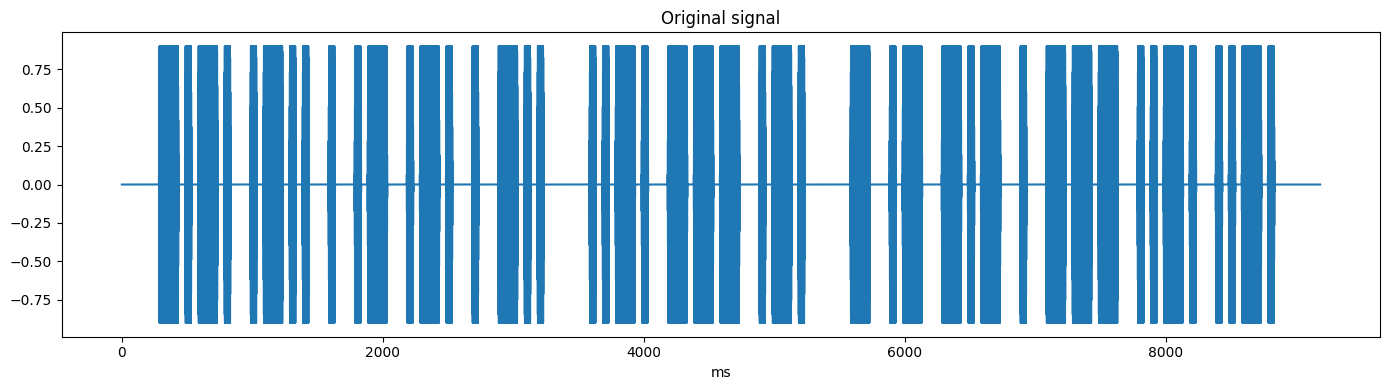

In [4]:
FILE_PATH = "./data/cleared_for_takeoff.txt"

freq, signal = read_signal_from_file(FILE_PATH)
plot_signals_in_ms({"Original signal": signal}, freq)

#### Обработка сигнала

Сигнал обрабатывается в четыре этапа:
- взятие по абсолютному значению,
- усреднение бегущим окном 10 мс (по 8 периодам несущей частоты),
- приведение сигнала к цифровому путём сравнения значений с пороговым (~2.865),
- сжатие сигнала (рассмотрено ниже).

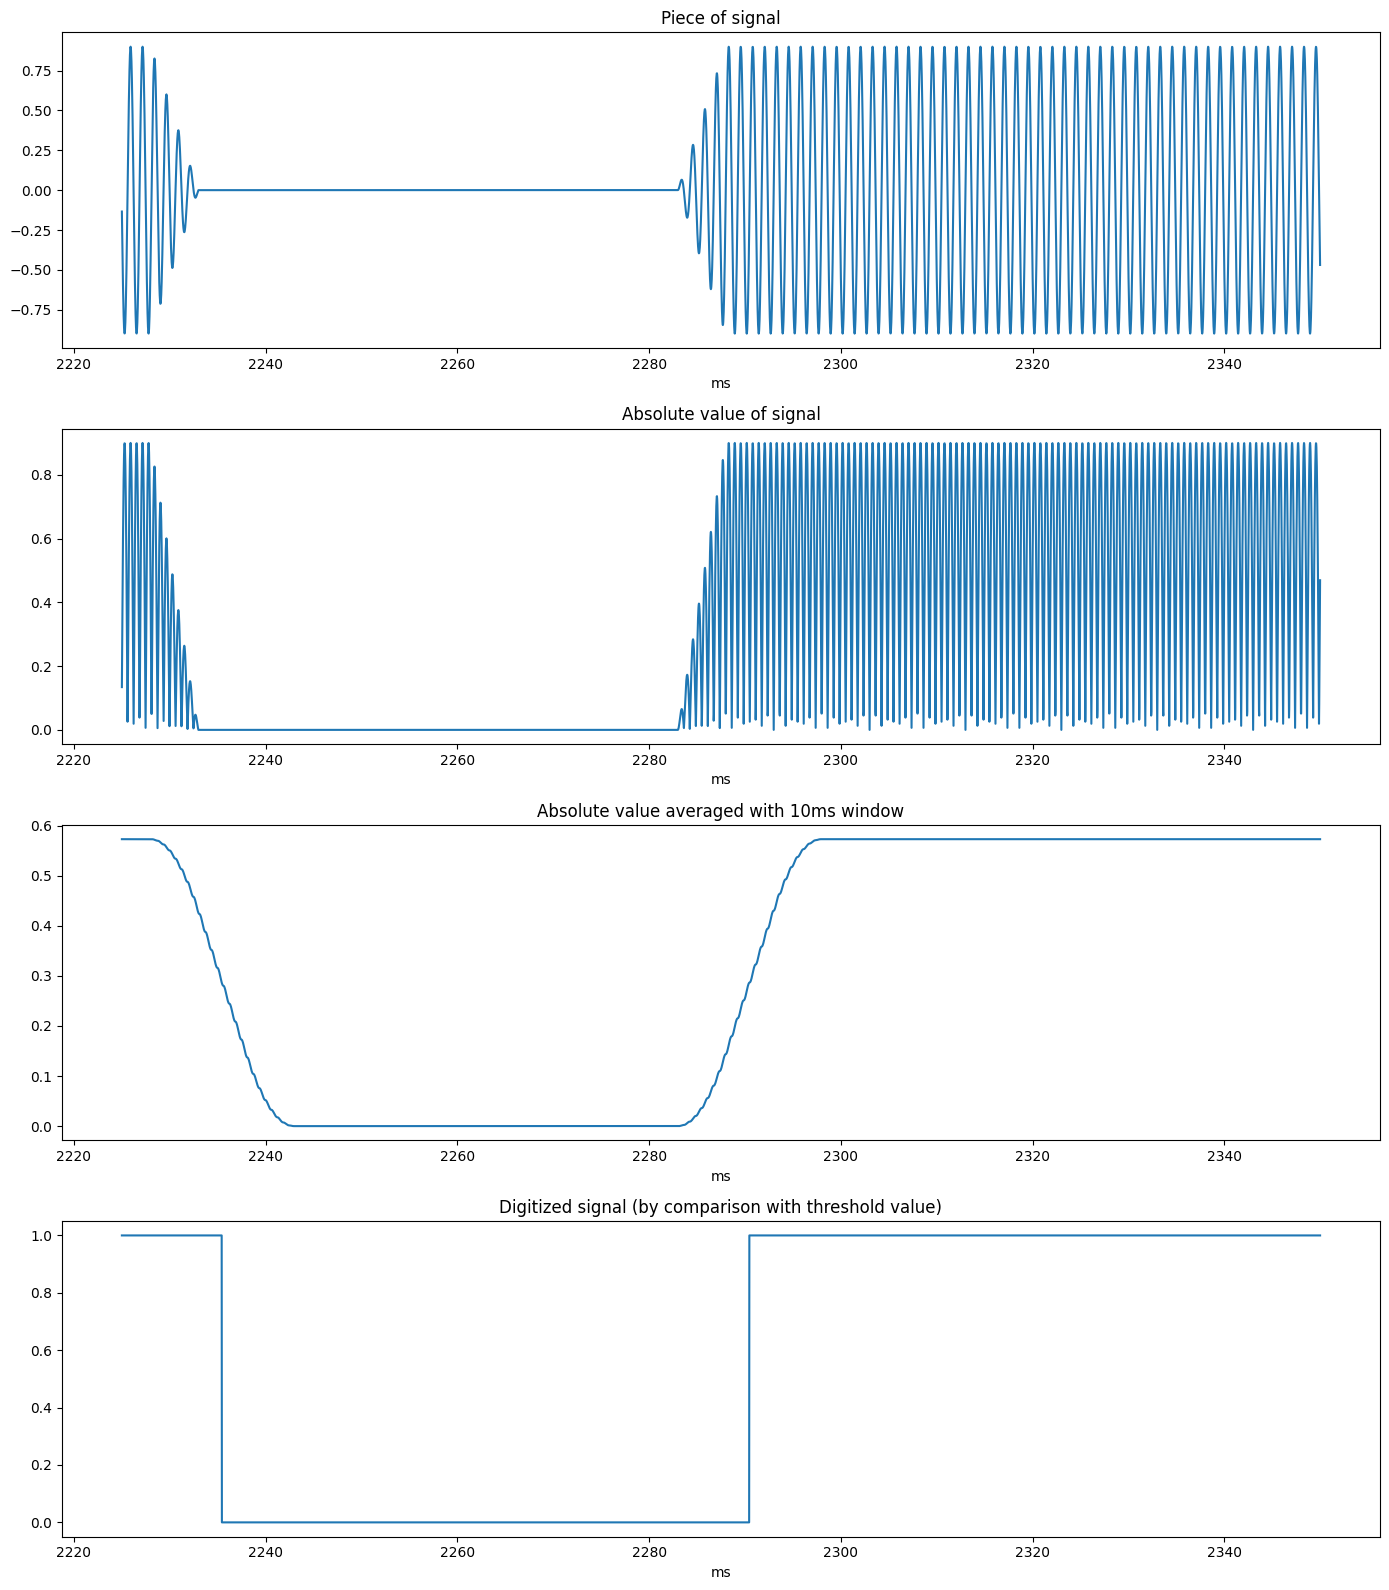

In [5]:
piece = slice(
    milliseconds_to_timedelta(2225), 
    milliseconds_to_timedelta(2350),
)

averaged_signal = signal.abs().rolling(window="10L").mean()

mean_value = (averaged_signal.max() - averaged_signal.min()) / 2
digital_signal = (averaged_signal > mean_value)


signals_to_plot = {
    "Piece of signal": signal[piece],
    "Absolute value of signal": signal.abs()[piece],
    "Absolute value averaged with 10ms window": averaged_signal[piece],
    "Digitized signal (by comparison with threshold value)": digital_signal[piece].astype(int),
}
plot_signals_in_ms(signals_to_plot, freq)

#### Сжатие цифрового сигнала

Частота дискретизации исходного сигнала (44100 Гц) достаточно высока чтобы разрешать несущую частоту в 800 Гц (55.125 точек на период). При этом характерное время полезного сигнала - 50 мс - длина одной "точки". В качестве подбираемого параметра оптимизации используется минимальное количество измерений на одну "точку". Подобрав наиболее низкое значение данного параметра, не приводящее к появлению ошибок при распознавании сигнала, можно значительно уменьшить объём данных на последующих этапах анализа!

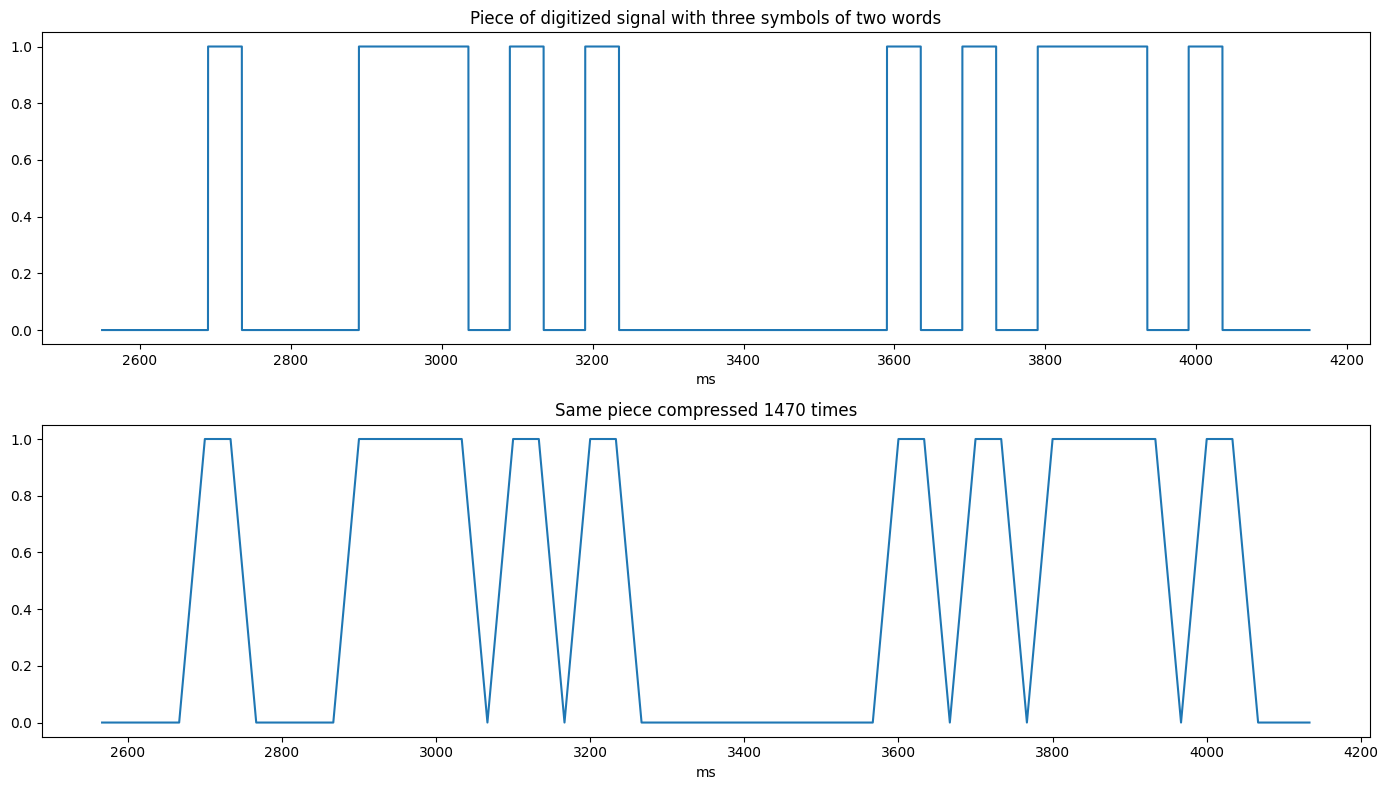

In [6]:
POINTS_PER_DOT = 1.5  # минимальное количество измерений на одну "точку" (для оптимизации алгоритма)
DOT_DURATION = 50  # заявленная длительность одной "точки" (ms)

compressed_digital_signal = compress_signal(digital_signal, freq, POINTS_PER_DOT, DOT_DURATION)

piece = slice(
    milliseconds_to_timedelta(2550), 
    milliseconds_to_timedelta(4150),
)

signals_to_plot = {
    "Piece of digitized signal with three symbols of two words": digital_signal[piece].astype(int),
    "Same piece compressed 1470 times": compressed_digital_signal[piece].astype(int),
}
plot_signals_in_ms(signals_to_plot, freq)

#### Распознавание цифрового сигнала

Чтобы распознать полученный цифровой сигнал, представим его в виде последовательности отрезков отсутствия сигнала и его наличия, каждый отрезок характеризуется своей продолжительностью. 

In [7]:
peak_durations = []
spacer_durations = []

peak_start, spacer_start = 0, None
state = False
for time, point in digital_signal.items():
    if not state and point:
        peak_start = time
        if spacer_start:
            spacer_durations.append((time - spacer_start).microseconds / 1000)
    if state and not point:
        spacer_start = time
        peak_durations.append((time - peak_start).microseconds / 1000)
    state = point

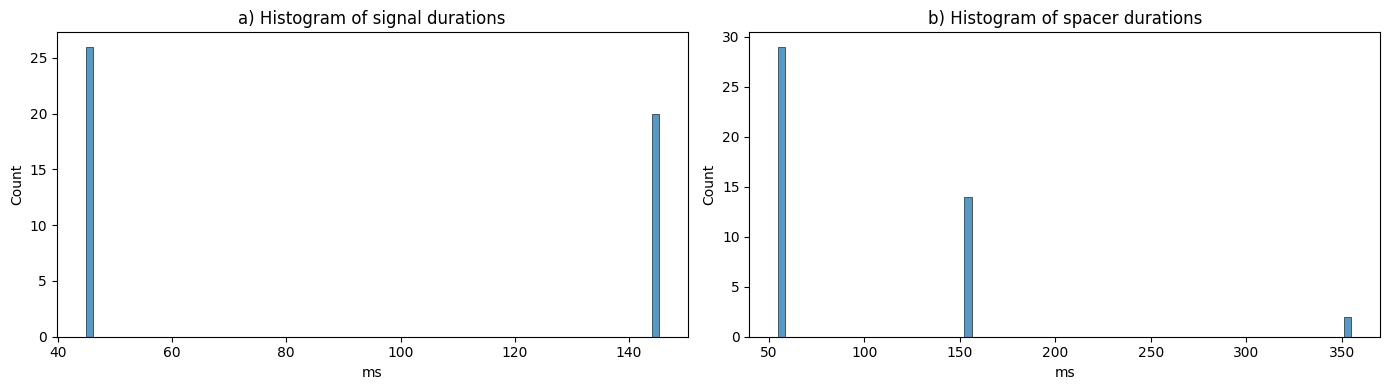

In [8]:
N_BINS = 80
fig, (ax_signal, ax_spacer) = plt.subplots(1, 2, figsize=(14, 4))
[a.set_xlabel("ms") for a in (ax_signal, ax_spacer)]

ax_signal.set_title("a) Histogram of signal durations")
sns.histplot(peak_durations, bins=N_BINS, ax=ax_signal)

ax_spacer.set_title("b) Histogram of spacer durations")
sns.histplot(spacer_durations, bins=N_BINS, ax=ax_spacer)

fig.tight_layout()
plt.show()

a) На гисограмме длительностей сигнала чётко видны два пика:
- точки (45 мс),
- тире (145 мс)

В качестве порогового значения было взято их среднее арифметическое - 95 мс.

b) На гисограмме длительностей разделителей чётко видны три пика:
- разделители знаков внутри одного символа (55 мс),
- разделители символов (155 мс),
- разделители слов (355 мс)

В качестве порогового значения были взяты значения в 100 мс и 250 мс.

In [9]:
DASH_THRESHOLD = 95  # порог длительности тире (ms)
SYMBOL_THRESHOLD = 100  # порог длительности разделителя символов (ms)
SPACER_THRESHOLD = 250  # порог длительности разделителя слов (ms)

message = recognize_signal(compressed_digital_signal, SYMBOL_THRESHOLD, SPACER_THRESHOLD, DASH_THRESHOLD)

for i, word in enumerate(message):
    print(i, end=")\t")
    print(*word, sep="\t")

0)	-.-.	.-..	.	.-	.-.	.	-..
1)	..-.	---	.-.
2)	-	.-	-.-	.	---	..-.	..-.


Распознаны три слова из 7, 3 и 7 символов соответственно.

## Расшифровка кода Морзе

__Алгоритм__

Код Морзе представляется в виде последовательности нулей (точки) и единиц (тире) с ведущей единицей, данная двоичная запись преобразуется к десятичной со сдвигом на 2 (чтобы индексы начинались с нуля). Теперь символы кода можно расположить в массиве по соответствующим индексам, что позволит расшифровывать сообщение, не прибегая к сложным структурам типа бинарных деревьев.

In [10]:
# Функция для преобразования кода Морзе в целое число
def morse_code_to_decimal(code: str) -> int:
    return int("1" + code.replace("-", "1").replace(".", "0"), base=2) - 2


# Считываем код Морзе из файла и индексируем символы для быстрого декодирования
morse_df = pd.read_csv("morse_code.csv", header=None)
morse_df.columns = ("symbol", "code")
morse_df.index = morse_df.code.apply(morse_code_to_decimal).values
morse_df.sort_index(inplace=True)
morse_df

,symbol,code
0,E,.
1,T,-
2,I,..
3,A,.-
4,N,-.
5,M,--
6,S,...
7,U,..-
8,R,.-.
9,W,.--


In [11]:
decoded_message = decode_message(message)
print(decoded_message)

CLEARED FOR TAKEOFF 


Сообщение успешно расшифровано!

## Дешифровка набора данных

In [12]:
DATA_DIR = "./data/"

signals = [name for name in os.listdir(DATA_DIR) if name.endswith(".txt")]
path = [os.path.join(DATA_DIR, name) for name in signals]

for file_name, file_path in sorted(zip(signals, path)):
    freq, signal = read_signal_from_file(file_path)
    digital_signal = digitalize_signal(signal)
    compressed_digital_signal = compress_signal(digital_signal, freq, POINTS_PER_DOT, DOT_DURATION)
    message = recognize_signal(compressed_digital_signal, SYMBOL_THRESHOLD, SPACER_THRESHOLD, DASH_THRESHOLD)
    decoded_message = decode_message(message)

    print(f"File:     {file_name}\nContent:  {decoded_message.lower()}\n")

File:     cleared_for_takeoff.txt
Content:  cleared for takeoff 

File:     direct.txt
Content:  direct 

File:     go_around.txt
Content:  go around 

File:     hi.txt
Content:  hi 

File:     ok.txt
Content:  ok 

File:     to_infinity_and_beyond.txt
Content:  to infinity and beyond 

File:     unknown_1.txt
Content:  fifteen men on the dead mans chest yo ho ho, and a bottle of rum 

File:     unknown_2.txt
Content:  friends, remember this day when you almost caught captain jack sparrow 

